In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA, SPSA, L_BFGS_B, ADAM
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN

algorithm_globals.random_seed = 12345


In [2]:
#===================================================================================================================================
import seaborn as sns
from openpyxl import Workbook, load_workbook
import string

#===================================================================================================================================
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import*
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
#==================================================================================================================================
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
#===================================================================================================================================
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd 
import random
import os



In [3]:
from qiskit_aer import Aer

simulator = Aer.get_backend('aer_simulator')
simulator.set_options(device='GPU', blocking_qubits=23, blocking_enable=True)

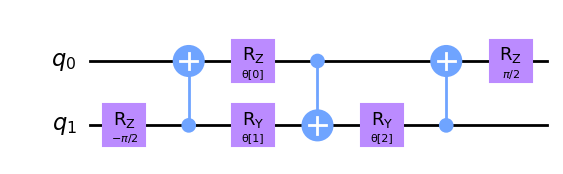

In [4]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

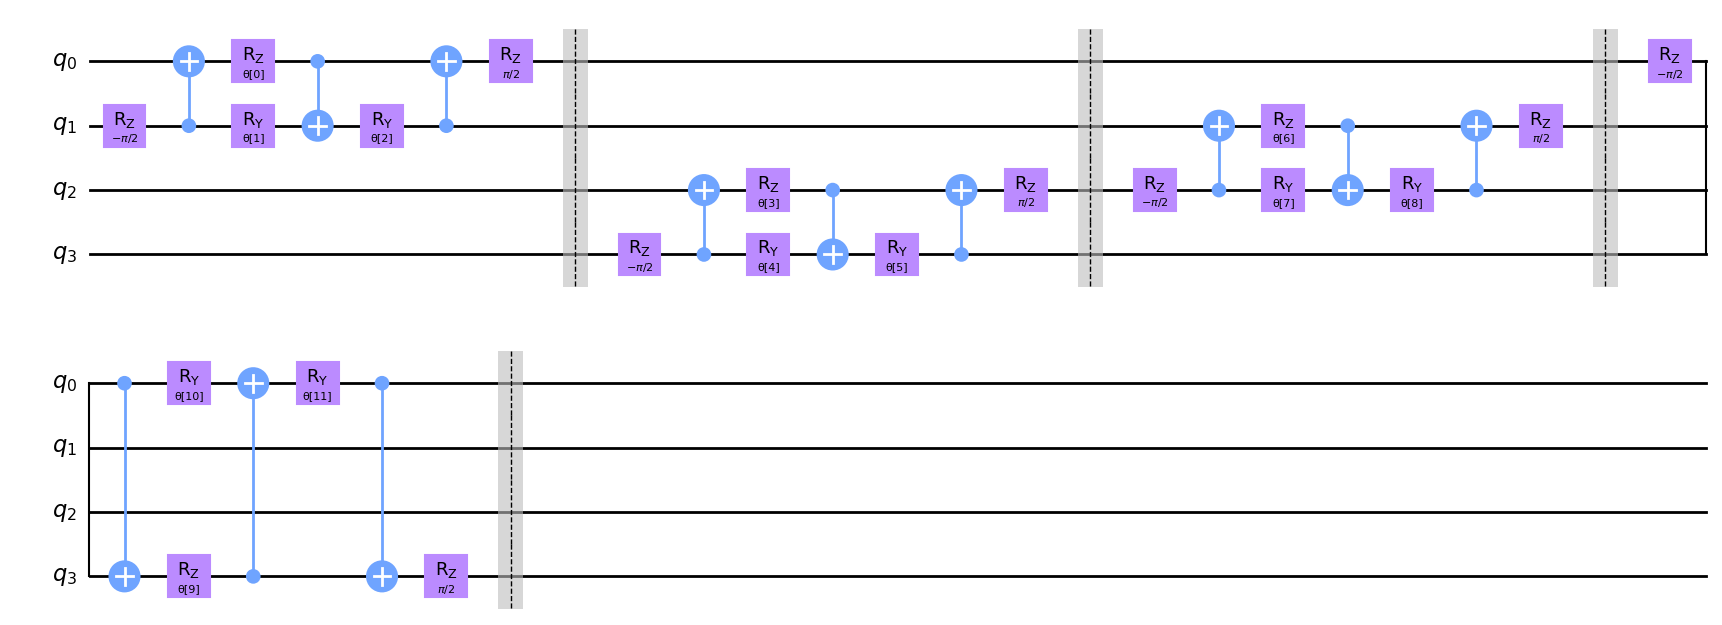

In [5]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

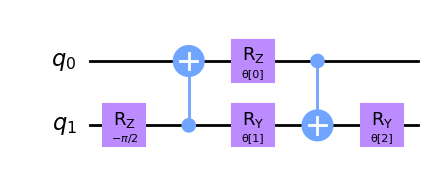

In [6]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

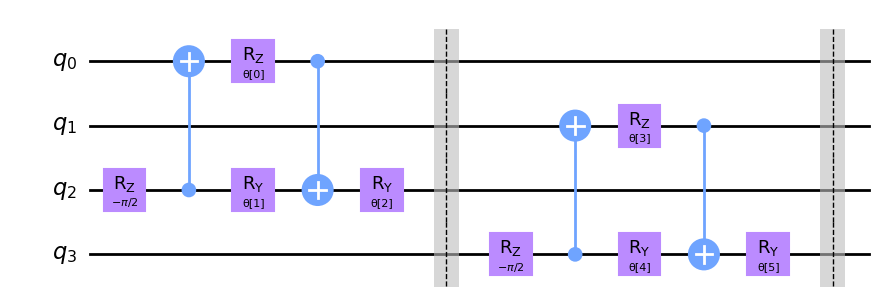

In [7]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

(49134, 69)


/tmp/ipykernel_536080/2930308404.py:25: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_NF = int(round(num_NF, 0))


<Axes: title={'center': 'Faults Distribution'}, ylabel='count'>

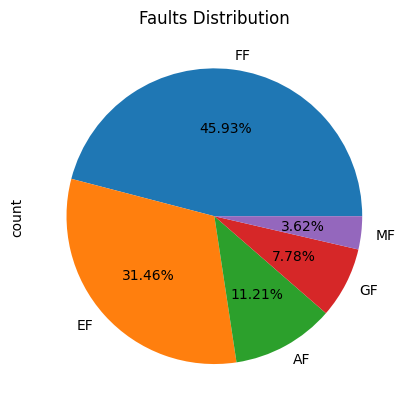

In [8]:
#======================================================= Parâmetros dos experimentos============================================================================
filename = "df_combine.csv"
path = os.path.join(os.getcwd(), 'compilacoes/data_exp_prepare')
df_combine = pd.read_csv(os.path.join(path, filename), low_memory=False)
df_combine.Fault.value_counts()
fault= [['AF', ]]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
savefig = False # Salvar Figuras
random_state = 80
numbers_features = 8 # Numeros de Features para serem selecionadas
batch_size = 400 # Tamanho dos batchs para treino
qLayers = 1  # Número de camadas do circuito quântico
perc_F_NF = 0.40  # Relação de falha com não falha
res_C = []
res_Q  = []
result_kernel = []
i = 0
#=================================================================================================================================================================

print(df_combine.shape)
df_nf_ = df_combine[df_combine.Fault=='NF']
df_f = df_combine[df_combine.Fault !='NF']

num_NF = (df_f['Fault'].value_counts()[fault[i]] - perc_F_NF*df_f['Fault'].value_counts()[fault[i]])/perc_F_NF
num_NF = int(round(num_NF, 0))

df_nf = df_combine[df_combine.Fault=='NF'].sample(num_NF, replace=True ,random_state=random_state) # SELECIONANDO 300 SAMPLES DE CASOS DE NÃO FALHA
df_combine = pd.concat((df_nf, df_f), axis=0).reset_index(drop=True)

df = df_combine.drop(columns=['DateTime_x', 'Time', 'Error', 'WEC: ava. windspeed', 
                                    'WEC: ava. available P from wind',
                                    'WEC: ava. available P technical reasons',
                                    'WEC: ava. Available P force majeure reasons',
                                    'WEC: ava. Available P force external reasons',
                                    'WEC: max. windspeed', 'WEC: min. windspeed', 
                                    'WEC: Operating Hours', 
                                    'WEC: Production minutes', 'DateTime_y'])


#df= df[(df['Fault'] == 'NF') | (df['Fault'] == fault[0][0])| (df['Fault'] == fault[0][1])| (df['Fault'] == fault[0][2])| (df['Fault'] == fault[0][3])| (df['Fault'] == fault[0][4])]
df= df[(df['Fault'] == 'NF') | (df['Fault'] == fault[0][0])]
df_f.Fault.value_counts().plot.pie(autopct = '%.2f%%', title = 'Faults Distribution')

In [9]:
df = df.sample(len(df))
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
le = LabelEncoder()
y = le.fit_transform(y)

for i in range(len(y)):
    if y[i] == 0:
        y[i] = 1
    elif y[i] == 1:
        y[i] = -1
        
        
df_combine.Fault.value_counts()


Fault
FF    254
EF    174
NF     93
AF     62
GF     43
MF     20
Name: count, dtype: int64

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif

def feature_selectionRFE(max_iter,data,X, y, numbers_features):
    std = StandardScaler()
    X = std.fit_transform(X)
    model = LogisticRegression(max_iter=max_iter)
    rfe = RFE(model,n_features_to_select=numbers_features)
    fit = rfe.fit(X,y)
    cols = fit.get_support(indices=True)
    features = data.iloc[:,cols]
    
    return features, cols

def feature_selectionKBest(X, y, numbers_features):
    std = StandardScaler()
    X = std.fit_transform(X)
    kbest = SelectKBest(score_func=f_classif, k=numbers_features)
    fit = kbest.fit(X,y)
    X_selected = kbest.fit_transform(X, y)

    return X_selected

In [11]:



X_RFE = feature_selectionRFE(max_iter=500,data = df, X=X, y=y, numbers_features=numbers_features)
X = X_RFE[0] # Redução de features
#X_Best = feature_selectionKBest(X=X, y=y, numbers_features=numbers_features)
#X =X_Best[0]

# Apply undersampling using RandomUnderSampler
#undersampler = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
#X, y = undersampler.fit_resample(X, y)
smote = smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)


test_size = 0.20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state= random_state)

print("Quantidade de DADOS DE FALHA/NAOFALHA", df.Fault.value_counts())
print("\n")
print("Quantidade de DADOS TOTAL", df.Fault.shape[0])
print(f"Porcentagem de DADOS PARA TREINO {(1-test_size)*100}%")
print(f"Porcentagem de DADOS PARA TESTE {(test_size)*100}%")
print(f"FORMATO X_train: {X_train.shape}\nFORMATO X_test: {X_test.shape}\nFormato y_train: {y_train.shape}\nFormato y_test: {y_test.shape}")
# Update n_features
n_features = X.shape[1]

# Now use X_selected instead of X in your quantum circuit

#print("Quantidade de FEATURES:", n_features)


Quantidade de DADOS DE FALHA/NAOFALHA Fault
NF    93
AF    62
Name: count, dtype: int64


Quantidade de DADOS TOTAL 155
Porcentagem de DADOS PARA TREINO 80.0%
Porcentagem de DADOS PARA TESTE 20.0%
FORMATO X_train: (148, 8)
FORMATO X_test: (38, 8)
Formato y_train: (148,)
Formato y_test: (38,)


In [12]:
# Scalling
std = StandardScaler()
X_train_prep = pd.DataFrame(std.fit_transform(X_train))
X_test_prep = pd.DataFrame(std.fit_transform(X_test))

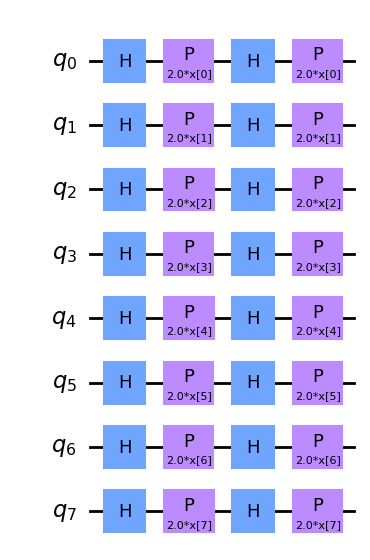

In [13]:
feature_map = ZFeatureMap(n_features)
feature_map.decompose().draw("mpl", style="clifford")

In [14]:
ansatz = QuantumCircuit(n_features, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(n_features, "c1"), list(range(n_features)), inplace=True)

# First Pooling Layer
n_qubits_after_pool1 = int(n_features / 2)  # This will be 27
ansatz.compose(pool_layer(list(range(n_qubits_after_pool1)), list(range(n_qubits_after_pool1, n_features)), "p1"), list(range(n_features)), inplace=True)

# Second Convolutional Layer
n_qubits_conv2 = n_features - n_qubits_after_pool1  # This will be 28
ansatz.compose(conv_layer(n_qubits_conv2, "c2"), list(range(n_qubits_after_pool1, n_features)), inplace=True)

# Second Pooling Layer
n_qubits_after_pool2 = int(n_qubits_conv2 / 2)  # This will be 14
ansatz.compose(pool_layer(list(range(n_qubits_after_pool2)), list(range(n_qubits_after_pool2, n_qubits_conv2)), "p2"), list(range(n_qubits_after_pool1, n_features)), inplace=True)

# Third Convolutional Layer
n_qubits_conv3 = int(n_qubits_conv2 - n_qubits_after_pool2)  # This will be 14
ansatz.compose(conv_layer(n_qubits_conv3, "c3"), list(range(n_features - n_qubits_conv3, n_features)), inplace=True)

# Third Pooling Layer
n_qubits_after_pool3 = n_qubits_conv3 // 2  # This will be 7
ansatz.compose(pool_layer(list(range(n_qubits_after_pool3)), list(range(n_qubits_after_pool3, n_qubits_conv3)), "p3"), list(range(n_features - n_qubits_conv3, n_features)), inplace=True)


In [15]:

# Combining the feature map and ansatz
circuit = QuantumCircuit(n_features)
circuit.compose(feature_map, range(n_features), inplace=True)
circuit.compose(ansatz, range(n_features), inplace=True)

n = n_features -1

observable = SparsePauliOp.from_list([("Z" + "I" * n, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)


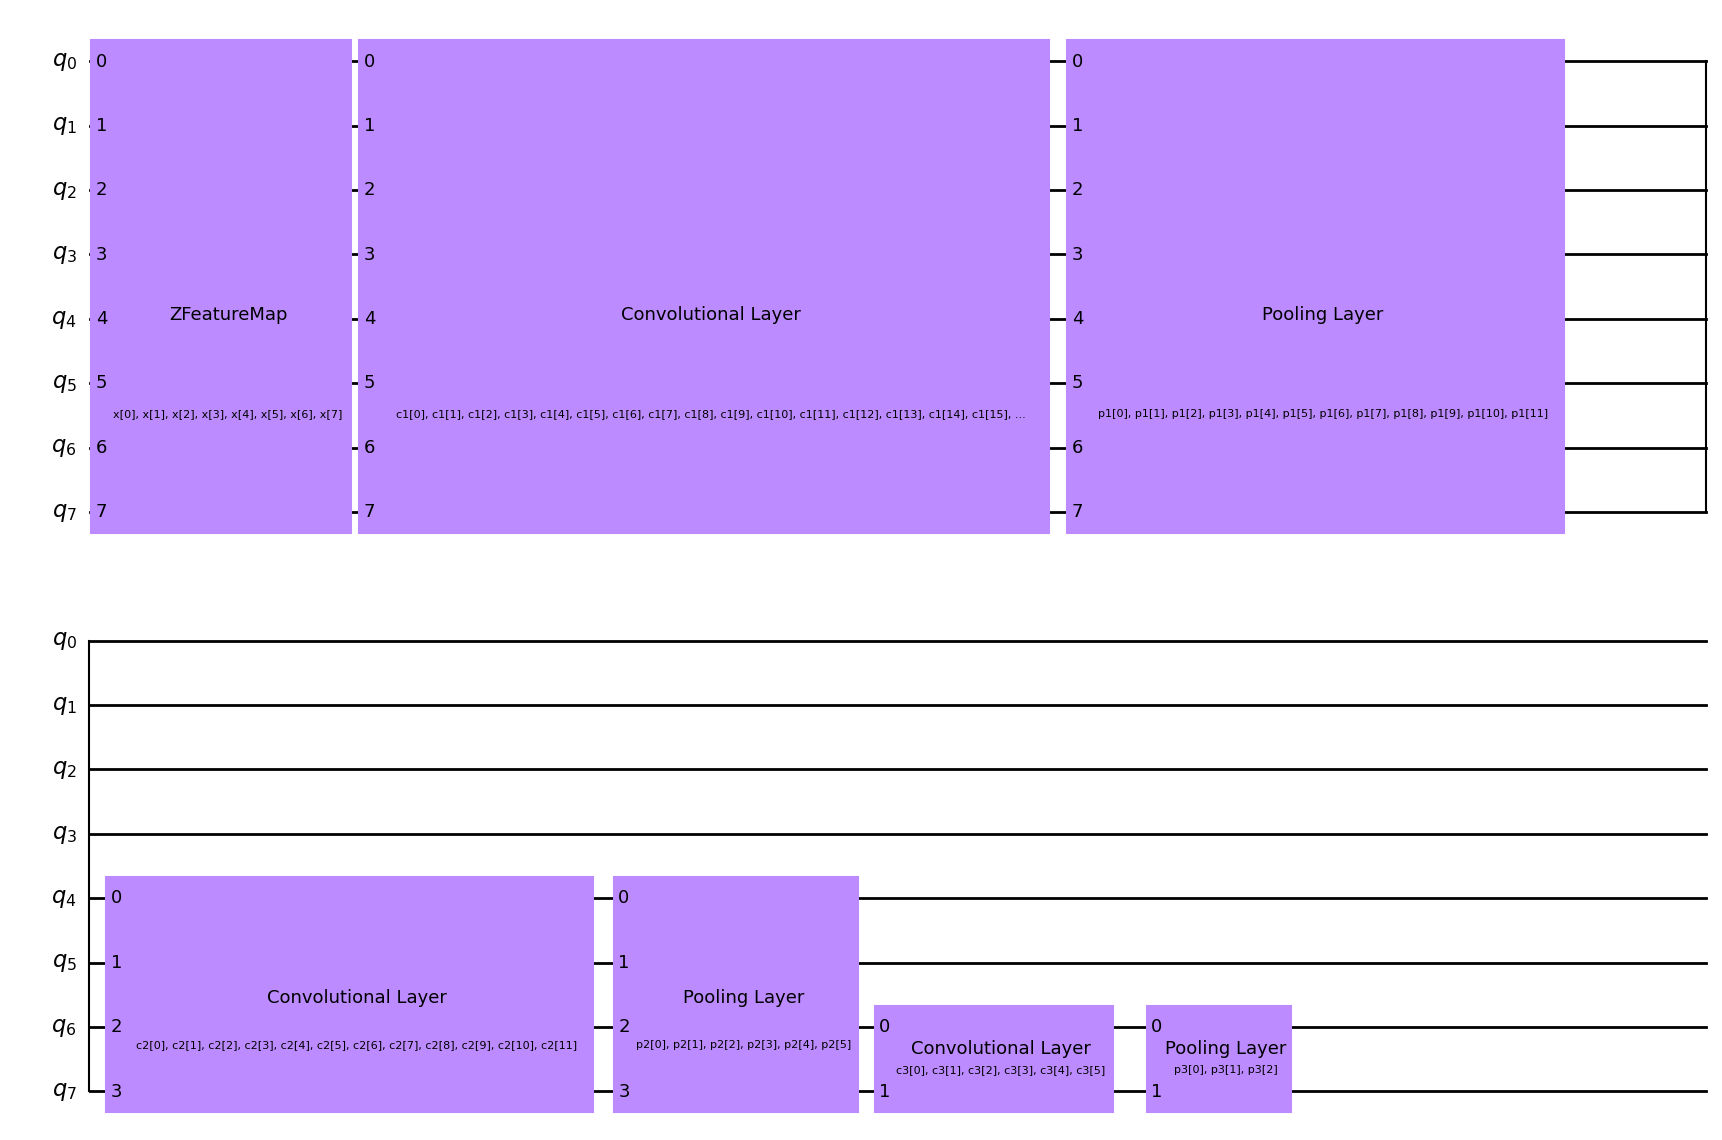

In [16]:
circuit.draw("mpl", style="clifford")

In [17]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [18]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=2000),  # Set max iterations here
    #optimizer=L_BFGS_B(maxiter=50),
    callback=callback_graph,
    #initial_point=initial_point,
)

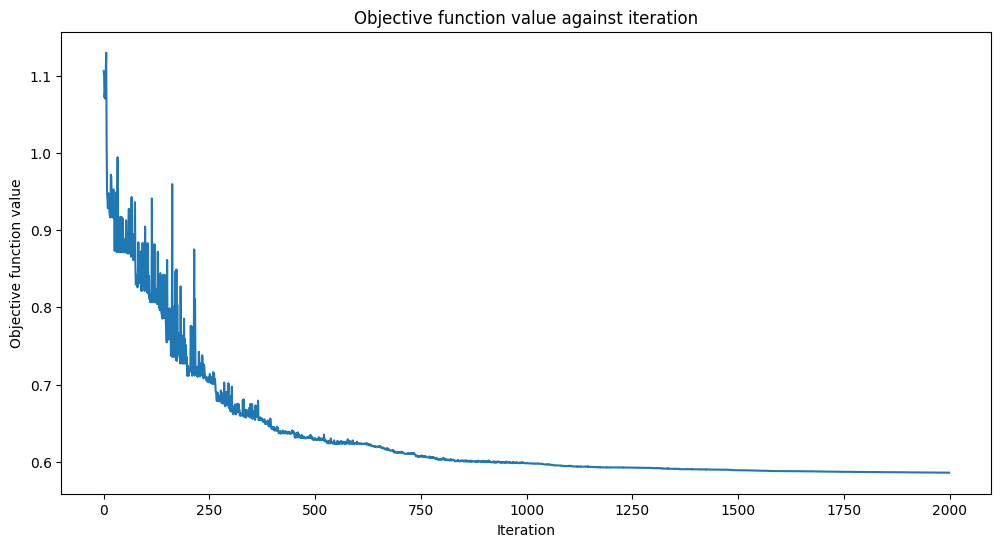

Accuracy from the train data : 86.49%


In [19]:
x = np.asarray(X_train_prep)
y = np.asarray(y_train)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

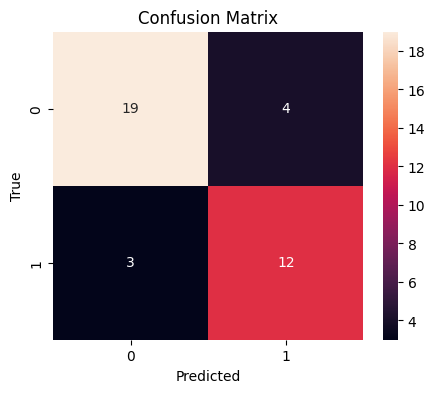

,Accuracy,Precision,Recall,F1_Score
0,81.579,81.579,81.579,81.579


In [20]:
y_pred = classifier.predict(X_test_prep)
y_true = np.asarray(y_test)
average ='micro'

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

pd.DataFrame({"Accuracy": round(accuracy_score(y_true, y_pred)*100,3),"Precision": round(precision_score(y_true, y_pred, average=average)*100,3),"Recall": round(recall_score(y_true, y_pred, average=average)*100,3),"F1_Score": round(f1_score(y_true, y_pred,average=average)*100,3),}, index = range(4)).head(1)
  
    